In [1]:
# Import packages
from google.colab import files

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import re
import string
import nltk
from collections import Counter
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob

from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [3]:
# Import customer complaints dataset
df = pd.read_csv("complaints_processed.csv")

# **Data Exploration & Visualisation (EDA)**

In [ ]:
# Look at the first few rows of the dataset
df.head()

,Unnamed: 0,product,narrative
0,0,credit_card,purchase order day shipping amount receive pro...
1,1,credit_card,forwarded message date tue subject please inve...
2,2,retail_banking,forwarded message cc sent friday pdt subject f...
3,3,credit_reporting,payment history missing credit report speciali...
4,4,credit_reporting,payment history missing credit report made mis...


In [ ]:
# Look at the data types of each column
print(df.dtypes)

Unnamed: 0     int64
product       object
narrative     object
dtype: object


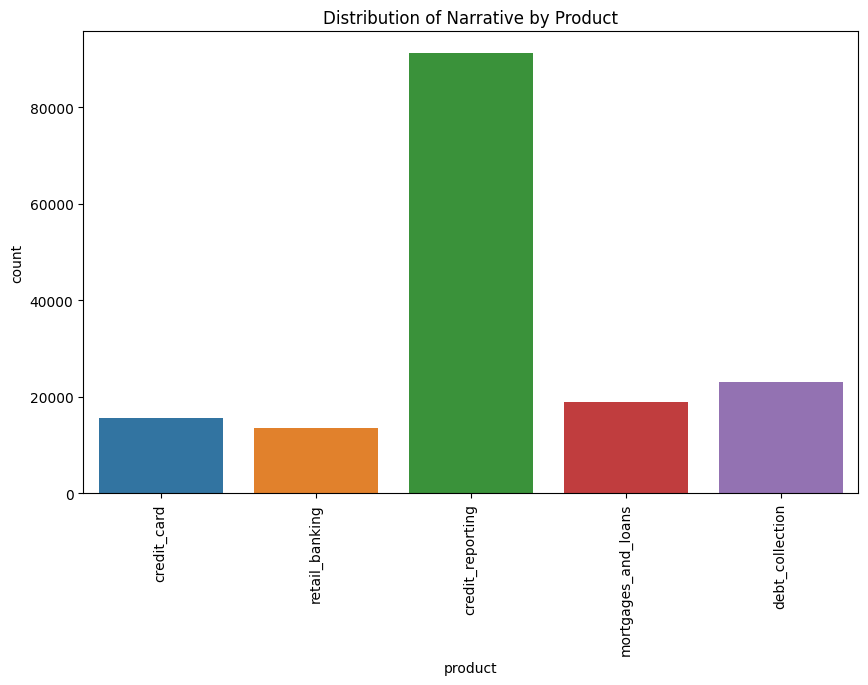

In [ ]:
# Visualize the distribution of complaints by product
plt.figure(figsize=(10,6))
sns.countplot(x='product', data=df)
plt.xticks(rotation=90)
plt.title('Distribution of Narrative by Product')
plt.show()

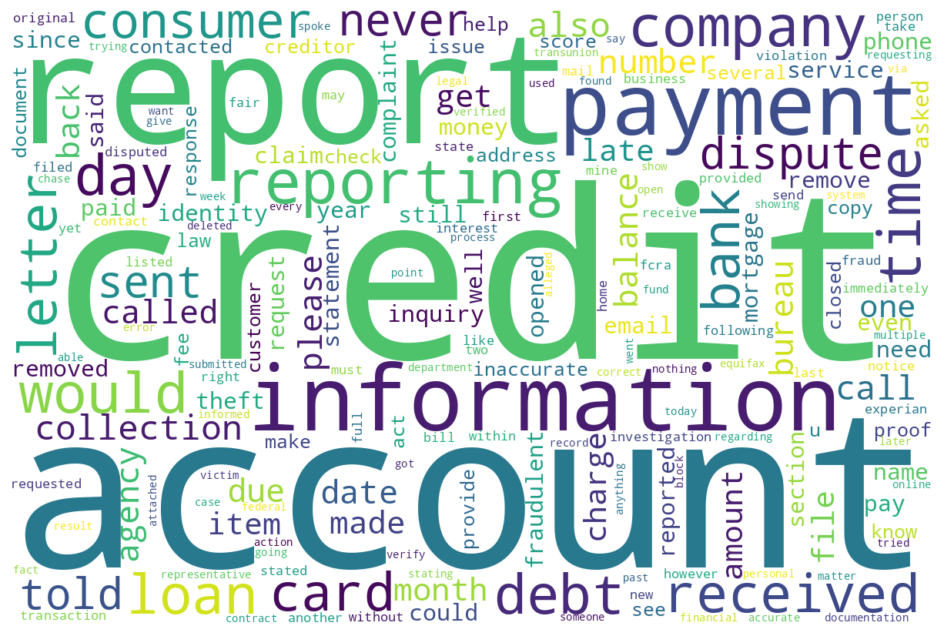

In [ ]:
# Create a WordCloud based on the most frequent words in narrative column
# Combine all the narratives into a single string
narratives = ' '.join(df['narrative'].dropna())

# Tokenize the string into words
words = nltk.word_tokenize(narratives.lower())

# Remove stop words from the list of words
stop_words = set(stopwords.words('english'))
words = [word for word in words if word not in stop_words]

# Count the frequency of each word
word_freq = Counter(words)

# Create a word cloud from the most common words
wordcloud = WordCloud(background_color='white', width=1200, height=800).generate_from_frequencies(word_freq)

# Plot the word cloud
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
# Identify any missing values in the dataset
print('Missing values:\n', df.isnull().sum())

Missing values:
 Unnamed: 0     0
product        0
narrative     10
dtype: int64


In [ ]:
# Print the rows with the missing values
missing_rows = df[df.isnull().any(axis=1)]
print(missing_rows)

        Unnamed: 0           product narrative
1089          1089  credit_reporting       NaN
3954          3954  credit_reporting       NaN
3955          3955  credit_reporting       NaN
29690        29690  credit_reporting       NaN
139436      139436   debt_collection       NaN
151052      151052   debt_collection       NaN
154494      154494  credit_reporting       NaN
156902      156902    retail_banking       NaN
158538      158538  credit_reporting       NaN
159503      159503  credit_reporting       NaN




# **Data Cleaning & Preprocessing**

In [4]:
# Drop the missing rows
df1 = df.dropna()
df1

,Unnamed: 0,product,narrative
0,0,credit_card,purchase order day shipping amount receive pro...
1,1,credit_card,forwarded message date tue subject please inve...
2,2,retail_banking,forwarded message cc sent friday pdt subject f...
3,3,credit_reporting,payment history missing credit report speciali...
4,4,credit_reporting,payment history missing credit report made mis...
...,...,...,...
162416,162416,debt_collection,name
162417,162417,credit_card,name
162418,162418,debt_collection,name
162419,162419,credit_card,name


In [5]:
def clean_text(text):
    # Remove URLs from text
    text = re.sub(r'http\S+', '', text)
    # Remove HTML tags from text
    text = re.sub(r'<.*?>', '', text)
    # Convert text to lowercase
    text = text.lower()
    # Remove contractions from text**
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    # Remove non-alphanumeric characters from text, especially the occurrence of ##**
    text = re.sub(r'[^\w\s#]', '', text).replace('#', '')
    # Remove punctuation from text
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove numbers from text
    text = re.sub(r'\d+', '', text)
    # Remove whitespaces from text**
    text = text.strip()
    # Remove string**
    text = re.sub(r"xxxxxxxx", " ", text)

    return text

In [6]:
def preprocess_data(df1):
    # Remove the "Unnamed: 0" column
    df1 = df1.drop(columns=['Unnamed: 0'])
    # Clean the "product" column
    df1['product'] = df1['product'].apply(lambda x: x.lower())
    # Clean the "narrative" column
    df1['narrative'] = df1['narrative'].apply(lambda x: clean_text(x))
    return df1

In [7]:
# Apply preprocessing function to create cleaned dataframe
df_clean = preprocess_data(df1)
df_clean.head()

,product,narrative
0,credit_card,purchase order day shipping amount receive pro...
1,credit_card,forwarded message date tue subject please inve...
2,retail_banking,forwarded message cc sent friday pdt subject f...
3,credit_reporting,payment history missing credit report speciali...
4,credit_reporting,payment history missing credit report made mis...


In [8]:
# Remove rows with duplicates based on the 'narrative' column
df_clean = df_clean.drop_duplicates(subset=['narrative'], keep=False)
df_clean.head()

,product,narrative
0,credit_card,purchase order day shipping amount receive pro...
1,credit_card,forwarded message date tue subject please inve...
2,retail_banking,forwarded message cc sent friday pdt subject f...
3,credit_reporting,payment history missing credit report speciali...
4,credit_reporting,payment history missing credit report made mis...


In [10]:
# Export dataframe to CSV
df_clean.to_csv('customer_complaints_clean_vF.csv', index=False)
files.download('customer_complaints_clean_vF.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **TFIDF Vectorizer**

In [ ]:
def generate_tfidf_dataframe(df_clean, max_features=1000):
    # Create a TFIDF Vectorizer
    vectorizer = TfidfVectorizer(stop_words='english', max_features=max_features)
    # Fit the TFIDF vectorizer to the text data
    tfidf_data = vectorizer.fit_transform(df_clean['narrative'])
    feature_names = list(vectorizer.vocabulary_.keys())
    # Convert to create a df
    df_tfidf = pd.DataFrame(tfidf_data.toarray(), columns=feature_names)
    # Concatenate the original df with the new TF-IDF df
    df_tfidf_clean = pd.concat([df_clean, df_tfidf], axis=1)

    return df_tfidf_clean

In [ ]:
# Apply tfidf function to create cleaned dataframe
df_tfidf_clean = generate_tfidf_dataframe(df_clean)
df_tfidf_clean.head()

,product,narrative,purchase,order,day,receive,product,week,sent,email,...,navient,fine,veteran,tracking,wire,instruction,santander,exhibit,health,trans
0,credit_card,purchase order day shipping amount receive pro...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.061158,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
1,credit_card,forwarded message date tue subject please inve...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
2,retail_banking,forwarded message cc sent friday pdt subject f...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.057372,0.0,0.0,0.039958,0.0,0.0
3,credit_reporting,payment history missing credit report speciali...,0.000000,0.113826,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
4,credit_reporting,payment history missing credit report made mis...,0.000000,0.117199,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
5,credit_reporting,payment history missing credit report made mis...,0.000000,0.117243,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
6,credit_reporting,va date complaint experian credit bureau invol...,0.058801,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.101043,0.0,0.0
7,credit_reporting,account reported abbreviated name full name se...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.036274,...,0.0,0.0,0.0,0.0,0.069108,0.0,0.0,0.024066,0.0,0.0
8,credit_reporting,account reported abbreviated name full name se...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.035793,...,0.0,0.0,0.0,0.0,0.068192,0.0,0.0,0.023747,0.0,0.0
9,credit_reporting,usdoexxxx account reported abbreviated name fu...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.035361,...,0.0,0.0,0.0,0.0,0.067369,0.0,0.0,0.023460,0.0,0.0


In [ ]:
# Export dataframe to CSV
df_tfidf_clean.to_csv('customer_complaints_tfidf_vF.csv', index=False)
files.download('customer_complaints_tfidf_vF.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Glove Embeddings**

In [ ]:
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from tqdm import tqdm
tqdm.pandas()
def load_glove_vectors(glove_file):
    embeddings = {}
    with open(glove_file, 'r', encoding='utf-8') as file:
        for line in file:
            values = line.strip().split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

# pre-trained GloVe embeddings: https://nlp.stanford.edu/projects/glove/
glove_vectors = load_glove_vectors('glove.6B.100d.txt')

def get_glove_sentence_vector(sentence, embeddings):
    words = nltk.word_tokenize(sentence)
    words = [word for word in words if word in embeddings]
    if words:
        return np.mean([embeddings[word] for word in words], axis=0)
    else:
        return np.zeros(embeddings[next(iter(embeddings))].shape)

df_clean['glove_embeddings'] = df_clean['narrative'].progress_apply(lambda x: get_glove_sentence_vector(str(x), glove_vectors))

100%|██████████| 112191/112191 [01:17<00:00, 1455.57it/s]


In [ ]:
# View the glove dataset
df_glove_clean = df_clean
df_glove_clean.head()

,product,narrative,glove_embeddings
0,credit_card,purchase order day shipping amount receive pro...,"[-0.04047259, -0.0621301, 0.17535262, 0.040248..."
1,credit_card,forwarded message date tue subject please inve...,"[0.065104075, -0.1267785, 0.2019742, -0.011044..."
2,retail_banking,forwarded message cc sent friday pdt subject f...,"[0.023783827, -0.039261743, 0.13587694, -0.081..."
3,credit_reporting,payment history missing credit report speciali...,"[-0.011392645, 0.0926651, 0.28676218, -0.07419..."
4,credit_reporting,payment history missing credit report made mis...,"[0.010899793, 0.085215874, 0.31770104, -0.0901..."


In [ ]:
# Export dataframe to CSV
df_glove_clean.to_csv('customer_complaints_glove_vF.csv', index=False)
files.download('customer_complaints_glove_vF.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>